In [504]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torchvision import datasets, transforms
from torch.autograd import Variable

import os
import os.path

import pandas as pd
import numpy as np

from PIL import Image
from collections import namedtuple
from tqdm import tnrange as trange, tqdm_notebook as tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
Args = namedtuple("Args", ["batch_size", "test_batch_size", "epochs", "seed"])
args = Args(64, 1000, 25, 1, 1337)

In [637]:
class DatasetFolder(data.Dataset):
    """A generic data loader where the samples are arranged in this way: ::
        root/class_x/xxx.ext
        root/class_x/xxy.ext
        root/class_x/xxz.ext
        root/class_y/123.ext
        root/class_y/nsdf3.ext
        root/class_y/asd932_.ext
    Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        samples (list): List of (sample path, class_index) tuples
    """


    def __init__(self, root, transform=None, target_transform=None):
        samples, classes = self.make_dataset(root)
        
        self.root = root

        self.classes = classes
        self.samples = samples

        self.transform = transform
        self.target_transform = target_transform


    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target


    def __len__(self):
        return len(self.samples)


    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


    def loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')


    def make_dataset(self, dir):
        images = []

        sample_classes = pd.read_csv(os.path.join(dir, "gt.csv")).set_index("filename").to_dict()["class_number"]
        classes = set(range(max(sample_classes.values()) + 1))

        dir = os.path.expanduser(dir)
        for img in sorted(os.listdir(dir)):
            filepath = os.path.join(dir, img)
            if img not in sample_classes:
                continue
                
#             with open(filepath, 'rb') as f:
#                 img_ = Image.open(f)
#                 img_ = np.array(img_.convert('RGB'))
                
#                 if max(img_.shape) < 50:
#                     continue
                

            item = (filepath, sample_classes[img])
            images.append(item)

        return images, classes

In [638]:
train_loader = torch.utils.data.DataLoader(
    DatasetFolder(
        "rtsd-r3/train",
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.3, 0.3, 0.3),
            transforms.RandomRotation(25),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])
    ),
    batch_size=args.batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    DatasetFolder(
        "rtsd-r3/test",
        transform=transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])
    ),
    batch_size=args.batch_size,
    shuffle=True
)

In [639]:
num_classes = len(train_loader.dataset.classes)

num_classes

106

In [640]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 25, kernel_size=3, padding=1),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(25, 37, kernel_size=3, padding=1),
            nn.BatchNorm2d(37),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(37, 50, kernel_size=3, padding=1),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.Conv2d(50, num_classes, kernel_size=1, padding=0),
        )


    def get_heatmaps(self, x):
        x = self.net(x)
        return x


    def forward(self, x):
        heatmap = self.get_heatmaps(x)
        x = F.avg_pool2d(heatmap, heatmap.shape[-2:])
        x = x.view(-1, num_classes)
        return heatmap, x


    def get_metrics(self, input_, target):
        if model.training:
            data = Variable(input_)
        else:
            data = Variable(input_, volatile=True)
            
        target = Variable(target)
        
        heatmap, output = self(data)
        
        loss = F.cross_entropy(output, target)
        
        if self.training:
            reg_loss = heatmap.abs().mean()
            loss += reg_loss
        
        pred = output.data.max(1, keepdim=True)[1]
        acc = pred.eq(target.data.view_as(pred)).type(torch.FloatTensor).mean()

        return loss, acc

In [641]:
model = Net()

optimizer = optim.RMSprop(model.parameters())

In [642]:
def train(epoch):
    model.train()
    
    smooth_loss = None
    smooth_acc = None
    
    def update_smooth(smooth, val, gamma=0.99):
        if smooth is not None:
            return (smooth * gamma + val * (1-gamma))
        else:
            return val
    
    tqdm_train_loader = tqdm(train_loader)
    
    for data, target in tqdm_train_loader:
        optimizer.zero_grad()
        
        loss, accuracy = model.get_metrics(data, target)        

        loss.backward()
        optimizer.step()
        
        smooth_loss = update_smooth(smooth_loss, loss.data.mean())
        smooth_acc = update_smooth(smooth_acc, accuracy)
        
        tqdm_train_loader.set_description('epoch: {} | loss: {:.6f} | acc: {:.6f}'.format(epoch, smooth_loss, smooth_acc))
        
    return smooth_acc, smooth_loss

In [643]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        loss, accuracy = model.get_metrics(data, target)
        
        test_loss += loss.data[0] * len(data)
        correct += accuracy * len(data)

    test_loss /= len(test_loader.dataset)
    print('Test set | loss: {:.6f} | accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))

In [644]:
for epoch in trange(1, args.epochs + 1):
    train(epoch)
    test()

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1105), HTML(value='')))

Test set | loss: 2.400952 | accuracy: 10342.0/22967 (45.03%)



HBox(children=(IntProgress(value=0, max=1105), HTML(value='')))

Test set | loss: 2.477113 | accuracy: 10653.0/22967 (46.38%)



HBox(children=(IntProgress(value=0, max=1105), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
batch, label = next(iter(test_loader))

image = batch.numpy()[0]
class_ = label.numpy()[0]

heatmap = model.get_heatmaps(Variable(batch)).data.numpy()[0]

heatmap = np.stack([np.array(transforms.Resize((64))(Image.fromarray(heatmap[i]))) for i in range(len(heatmap))])

In [ ]:
fig, axs = plt.subplots(10, 7, figsize=(11, 15))
predict = model.forward(Variable(batch))[1].data.numpy()[0]
print(np.argmax(predict), class_)

predict_ = np.argmax(predict)
axs[0][0].imshow(image.transpose(1,2,0), alpha=1)
axs[0][0].set_xticks([])
axs[0][0].set_yticks([])

fig.delaxes(axs[-1, -1])
fig.delaxes(axs[-1, -2])

plt.margins(0)

for i, (ax, img, conf) in enumerate(zip(axs.flatten()[1:], list(heatmap), predict)):
    ax.imshow(img, cmap="seismic",  alpha=1, vmin=heatmap.min(), vmax=heatmap.max())
    ax.set_title("{}: {:.3f}{}{}".format(i, conf, "; T" if i==class_ else "", "; P" if i==predict_ else ""))
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

plt.savefig("fig.jpg")

In [583]:
exs = {}
counts = {}

s = DatasetFolder(
        "rtsd-r3/train",
        transform=transforms.Compose([
            transforms.ToTensor(),
        ]))


for img, t in s:
    if t not in exs:
        exs[t] = img
        counts[t] = 0
    counts[t] += 1

In [584]:
len(exs)

104

In [586]:
exs.keys()

dict_keys([24, 9, 18, 80, 79, 77, 25, 56, 64, 67, 50, 7, 93, 96, 74, 101, 75, 11, 94, 2, 71, 100, 99, 95, 72, 84, 65, 8, 27, 57, 73, 102, 17, 23, 45, 98, 28, 105, 1, 44, 43, 42, 4, 13, 3, 20, 48, 46, 54, 31, 29, 35, 39, 47, 26, 40, 103, 58, 12, 21, 59, 104, 68, 63, 55, 62, 32, 49, 66, 19, 85, 97, 51, 61, 83, 14, 90, 36, 16, 5, 6, 92, 30, 37, 60, 38, 10, 15, 76, 70, 0, 78, 53, 87, 86, 91, 69, 81, 88, 33, 41, 82, 22, 34])

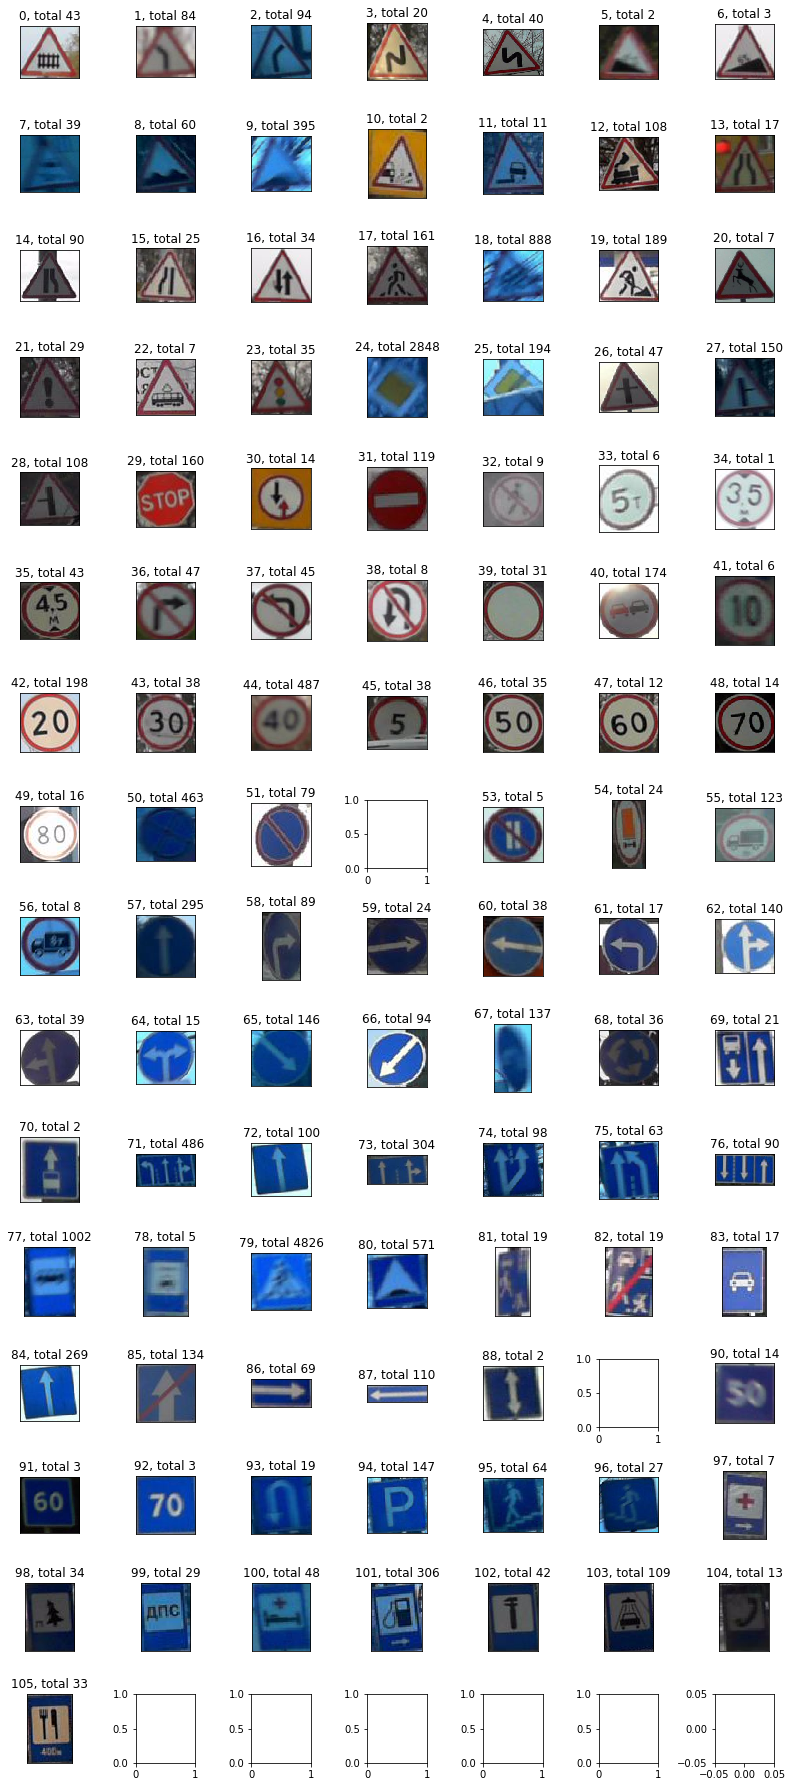

In [590]:
fig, axs = plt.subplots(16, 7, figsize=(11, 25))

plt.margins(0)

for i in exs.keys():
    axs.flatten()[i].imshow(exs[i].numpy().transpose(1, 2, 0))
    axs.flatten()[i].set_title("{}, total {}".format(i, counts[i]))
    axs.flatten()[i].set_xticks([])
    axs.flatten()[i].set_yticks([])
fig.tight_layout()

plt.savefig("ex.jpg")

In [594]:
np.mean(np.array(list(counts.values())) < 40)

0.5

In [596]:
max(counts.values())

4826